In [14]:
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities

import sklearn 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn
import scipy 
import nltk 
import string

import pickle 

import spacy


nlp = spacy.load("en_core_web_sm")

%matplotlib inline

In [9]:
# read in and inspect
election_tweets = pd.read_excel("./electionday_tweets.xlsx")

election_tweets.head()

,is_fake_news,fake_news_category,tweet_id,created_at,retweet_count,text,user_screen_name,user_verified,user_friends_count,user_followers_count,user_favourites_count,tweet_source,geo_coordinates,num_hashtags,num_mentions,num_urls,num_media
0,False,NaN,264033382076407808,Thu Nov 01 15:57:18 +0000 2012,4698,@realDonaldTrump you are full of shit!,RalphGilles,True,763,26680,3079,"<a href=""http://twitter.com/download/iphone"" r...",0,0,2,0,0
1,False,NaN,265895586660757505,Tue Nov 06 19:17:02 +0000 2012,9646,@realDonaldTrump you're fucking retarded,TimmyWait,False,839,397,504,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,0,2,0,0
2,False,NaN,265895723445411841,Tue Nov 06 19:17:35 +0000 2012,1823,@realDonaldTrump You are the stupidest man on ...,mattcale52,False,1184,1353,3355,"<a href=""http://twitter.com/download/iphone"" r...",0,0,2,0,0
3,False,NaN,265896172726661120,Tue Nov 06 19:19:22 +0000 2012,1168,@realDonaldTrump I am continually amazed and t...,MichaelWHill,False,1603,704,1479,"<a href=""http://twitter.com/download/iphone"" r...",0,0,2,0,0
4,False,NaN,266042962650226688,Wed Nov 07 05:02:39 +0000 2012,1979,Hey @realDonaldTrump You Mad Bro?,ThePresObama,False,135,70218,931,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",0,0,2,0,0


## Text processing

In [20]:

def word_tokenize(word_list, model=nlp, MAX_LEN=1500000):
    '''
    Citation: 
                Bhargav Desikan & James Evans, 
                MACS 40500,
                Computational Content Analysis
                Tokenizer, Lucem Illud 2020 package
    '''
    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 
    # since we're only tokenizing, I remove RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner"])
    
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized


In [28]:
# tokenize text
election_tweets['tokenized_text'] = election_tweets['tokenized_text_2'] = [word_tokenize(text) for text in election_tweets['text']]

In [32]:
# list of tokens
tokens_list = election_tweets['tokenized_text']

#got to inspect to make sure it looks okay
tokens_list[1][:]

['@realdonaldtrump', 'you', "'re", 'fucking', 'retarded']

In [33]:
for i in range(len(tokens_list)):
    for j in range(len(tokens_list[i])):
        tokens_list[i][j]=tokens_list[i][j].lower()

In [34]:

mentions = {}

for tokens in tokens_list: #index into each word
    for word in tokens:
        if "@" in word: 
            word = '@'+word.translate(str.maketrans('', '', string.punctuation))
            if word not in mentions:
                mentions[word] = 0
            if word in mentions:
                mentions[word] += 1

In [35]:
len(mentions)

222

In [39]:
mentions["@barackobama"]

4

In [40]:
# call mentions network
mentions_network = nx.Graph()

In [41]:
# now we filter
for mention in mentions:
    if mentions[mention] > 2:
        mentions_network.add_node(mention, times_mentioned= mentions[mention], words=[])

In [42]:
len(mentions_network.nodes.data())

30

In [45]:
# building the network
all_texts = []

for tweet in tokens_list:
            
    for word in tweet: #index into each word
        if "@" in word:

            if word in mentions_network.nodes():
                for word_ in tweet:
                    if "@" in word_:
                        #print(token)
                        if word_ != word and word_ in mentions_network.nodes():

                            if (word, word_) not in mentions_network.edges():
                                mentions_network.add_edge(word, word_, weight = 0)
                            if (word, word_) in mentions_network.edges():
                                mentions_network.edges[(word, word_)]['weight'] += 1
                            mentions_network.nodes[word]['words'].append(tweet)
                            mentions_network.nodes[word_]['words'].append(tweet)
                            
                        break

/Users/reginacatipon/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


<Figure size 432x288 with 0 Axes>

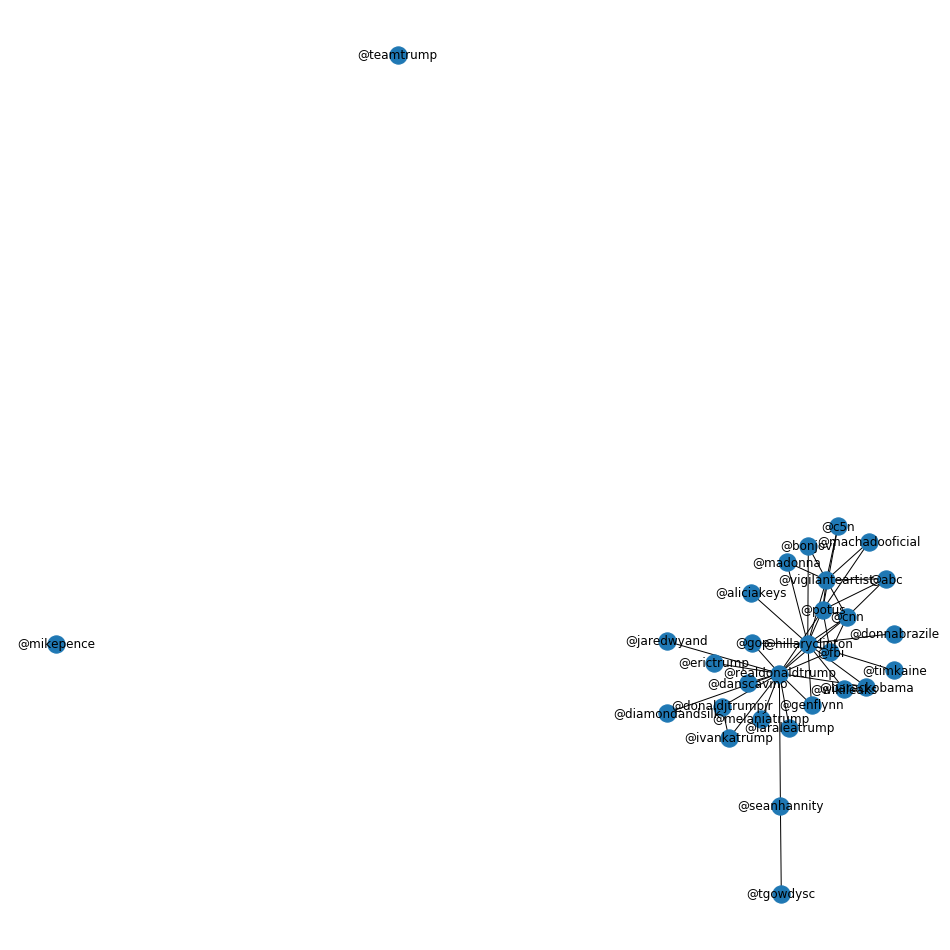

In [46]:
# smaller nodes and fonts
plt.figure(2)
# larger figure size
plt.figure(3,figsize=(13,13)) 
nx.draw(mentions_network, with_labels=True)
plt.show()

In [47]:
# from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(mentions_network))
c

[frozenset({'@barackobama',
            '@danscavino',
            '@diamondandsilk',
            '@donaldjtrumpjr',
            '@erictrump',
            '@genflynn',
            '@gop',
            '@ivankatrump',
            '@jaredwyand',
            '@laraleatrump',
            '@melaniatrump',
            '@realdonaldtrump',
            '@seanhannity',
            '@tgowdysc'}),
 frozenset({'@abc',
            '@aliciakeys',
            '@bonjovi',
            '@c5n',
            '@cnn',
            '@donnabrazile',
            '@fbi',
            '@hillaryclinton',
            '@machadooficial',
            '@madonna',
            '@potus',
            '@timkaine',
            '@vigilanteartist',
            '@wikileaks'}),
 frozenset({'@teamtrump'}),
 frozenset({'@mikepence'})]

In [48]:
dcentralities = nx.degree_centrality(mentions_network)
dcentralities['@potus'], dcentralities['@ivankatrump']

(0.27586206896551724, 0.06896551724137931)